In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
import sys
import os
sys.path.append(os.path.dirname('../.'))

#from scripts.load_and_save import (get_dcm_info, get_dcm_vol, vox_size2affine,
#                                   load_nii_vol, save_vol_as_nii, raw2nifti)
#from scripts.utils import print_img, print_imgs
#from scripts.hessian_based import hessian_detect_2016

from ml.controller import Controller
from ml.tio_dataset import TioDataset
from ml.models.HessNet import HessBlock, nn_detect, GaussianBlur3D, HessianTorch
from ml.metrics import (DICE_Metric, JAC_Metric, SN_Metric, SP_Metric,
                        IOU_Metric, ExponentialLogarithmicLoss)

In [4]:
PATCH_SIZE = 3*(64,)
DEVICE = 'cuda'

In [5]:
train_settings  = {
    "patch_shape" : PATCH_SIZE,
    "patches_per_volume" : 128,
    "patches_queue_length" : 1440,
    "batch_size" : 96,
    "num_workers": 4,
    "sampler": "uniform",#"weighted"
}

val_settings  = {
    "patch_shape" : PATCH_SIZE,
    "patches_per_volume" : 32,
    "patches_queue_length" : 1440,
    "batch_size" : 64,
    "num_workers": 4,
    "sampler": "uniform",#"weighted" #"uniform",#
}

test_settings  = {
    "patch_shape" : (64, 64, 64),
    "overlap_shape" : (16, 16, 16),
    "batch_size" : 1,
    "num_workers": 4,
}

data_dir = "/home/msst/Documents/medtech/data/HessData"
dataset = TioDataset(data_dir,
                 train_settings=train_settings,
                 val_settings=val_settings,
                 test_settings=test_settings)

In [6]:
model = HessBlock(start_scale=1, patch_size=PATCH_SIZE, device=DEVICE)

In [7]:
model

HessBlock(
  (linear): Sequential(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (hess): HessianTorch(
    (gauss): GaussianBlur3D(
      (conv): Conv3d(1, 1, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False, padding_mode=replicate)
    )
  )
  (flat): Flatten(start_dim=1, end_dim=4)
  (unflat): Unflatten(dim=1, unflattened_size=(64, 64, 64))
)

In [8]:
controller_config = {
    "loss" : ExponentialLogarithmicLoss(gamma_tversky=2, gamma_bce=2, lamb=0.5, freq = 0.1, tversky_alfa=0.55),
    "metric" : DICE_Metric(),
    'device' : DEVICE,
    "optimizer_fn" : lambda model: torch.optim.Adam(model.parameters(), lr=0.05),
    "sheduler_fn": lambda optimizer: StepLR(optimizer, step_size=10, gamma=0.5)
}
controller = Controller(controller_config)

cuda


In [9]:
controller.fit(model, dataset, 50)

Epoch 1/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


{'mean_loss': 12.338716234479632}


100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.23it/s]


{'mean_loss': 9.394306659698486}
tensor(0.3860)
Epoch 2/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


{'mean_loss': 9.679565293448311}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s]


{'mean_loss': 8.228748321533203}
tensor(0.1378)
Epoch 3/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


{'mean_loss': 8.33577333177839}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


{'mean_loss': 7.94957160949707}
tensor(0.2504)
Epoch 4/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.38it/s]


{'mean_loss': 7.345020430428641}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 6.234802484512329}
tensor(0.2408)
Epoch 5/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


{'mean_loss': 6.4247821399143765}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s]


{'mean_loss': 4.8799803256988525}
tensor(0.3358)
Epoch 6/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


{'mean_loss': 5.364763804844448}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]


{'mean_loss': 4.8980841636657715}
tensor(0.3734)
Epoch 7/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


{'mean_loss': 4.0157551765441895}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 3.0912333726882935}
tensor(0.3993)
Epoch 8/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


{'mean_loss': 3.2276078973497664}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s]


{'mean_loss': 2.875678777694702}
tensor(0.4960)
Epoch 9/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


{'mean_loss': 2.738657202039446}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s]


{'mean_loss': 1.966619610786438}
tensor(0.5525)
Epoch 10/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


{'mean_loss': 2.2284890753882274}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 1.842311978340149}
tensor(0.5715)
Epoch 11/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.45it/s]


{'mean_loss': 1.8131893532616752}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]


{'mean_loss': 2.1042096614837646}
tensor(0.5778)
Epoch 12/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.45it/s]


{'mean_loss': 1.6604827812739782}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


{'mean_loss': 1.7876018285751343}
tensor(0.5934)
Epoch 13/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


{'mean_loss': 1.5260154690061296}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


{'mean_loss': 1.4824437499046326}
tensor(0.6535)
Epoch 14/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.47it/s]


{'mean_loss': 1.856589334351676}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


{'mean_loss': 1.2634819746017456}
tensor(0.5776)
Epoch 15/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.31it/s]


{'mean_loss': 1.4393053139959062}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]


{'mean_loss': 1.192406177520752}
tensor(0.6591)
Epoch 16/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.38it/s]


{'mean_loss': 1.2178194863455636}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 1.2915749549865723}
tensor(0.6136)
Epoch 17/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]


{'mean_loss': 1.138615003653935}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.34it/s]


{'mean_loss': 1.1561236381530762}
tensor(0.6567)
Epoch 18/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.38it/s]


{'mean_loss': 1.0378729275294714}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 1.323513686656952}
tensor(0.6327)
Epoch 19/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


{'mean_loss': 0.9846071004867554}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]


{'mean_loss': 0.8426831662654877}
tensor(0.6761)
Epoch 20/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


{'mean_loss': 1.0163108110427856}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]


{'mean_loss': 0.5803534090518951}
tensor(0.6570)
Epoch 21/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


{'mean_loss': 0.90239075251988}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s]


{'mean_loss': 0.6001534759998322}
tensor(0.6692)
Epoch 22/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.49it/s]


{'mean_loss': 0.822492241859436}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


{'mean_loss': 1.0076677799224854}
tensor(0.6921)
Epoch 23/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.45it/s]


{'mean_loss': 0.8444932954651969}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]


{'mean_loss': 0.7565315365791321}
tensor(0.6816)
Epoch 24/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


{'mean_loss': 0.755870350769588}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.38it/s]


{'mean_loss': 0.7453175485134125}
tensor(0.6789)
Epoch 25/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.39it/s]


{'mean_loss': 0.8053709438868931}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 1.0287780165672302}
tensor(0.6691)
Epoch 26/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


{'mean_loss': 0.7679549285343715}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.8249070048332214}
tensor(0.6790)
Epoch 27/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


{'mean_loss': 0.7853264382907322}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


{'mean_loss': 0.9350020587444305}
tensor(0.7011)
Epoch 28/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.51it/s]


{'mean_loss': 0.6619494812829154}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.6832666099071503}
tensor(0.6825)
Epoch 29/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


{'mean_loss': 0.690431467124394}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s]


{'mean_loss': 0.5668734312057495}
tensor(0.6774)
Epoch 30/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.54it/s]


{'mean_loss': 0.652048145021711}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.40it/s]


{'mean_loss': 0.6223225295543671}
tensor(0.6956)
Epoch 31/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


{'mean_loss': 0.5805184159960065}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]


{'mean_loss': 0.7290770709514618}
tensor(0.6929)
Epoch 32/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.56it/s]


{'mean_loss': 0.7496623992919922}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s]


{'mean_loss': 0.5665679574012756}
tensor(0.6960)
Epoch 33/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


{'mean_loss': 0.6378501057624817}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]


{'mean_loss': 0.521218478679657}
tensor(0.7018)
Epoch 34/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.45it/s]


{'mean_loss': 0.5854488781520298}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.6623414754867554}
tensor(0.6976)
Epoch 35/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.46it/s]


{'mean_loss': 0.6135845099176679}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.5675297528505325}
tensor(0.6887)
Epoch 36/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.39it/s]


{'mean_loss': 0.5774571256978172}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.6911967694759369}
tensor(0.6957)
Epoch 37/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.45it/s]


{'mean_loss': 0.6213172929627555}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]


{'mean_loss': 0.5552999377250671}
tensor(0.6993)
Epoch 38/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.39it/s]


{'mean_loss': 0.6359441024916512}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.5303116887807846}
tensor(0.7031)
Epoch 39/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.48it/s]


{'mean_loss': 0.6132502257823944}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.4955971986055374}
tensor(0.6969)
Epoch 40/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


{'mean_loss': 0.5681955771786826}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.53521728515625}
tensor(0.6983)
Epoch 41/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.44it/s]


{'mean_loss': 0.5497021462236132}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]


{'mean_loss': 0.4512013643980026}
tensor(0.7004)
Epoch 42/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


{'mean_loss': 0.5787159332207271}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


{'mean_loss': 0.5874273777008057}
tensor(0.7055)
Epoch 43/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.36it/s]


{'mean_loss': 0.612230943781989}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]


{'mean_loss': 0.563255563378334}
tensor(0.7039)
Epoch 44/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.40it/s]


{'mean_loss': 0.6011704206466675}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


{'mean_loss': 0.4287869781255722}
tensor(0.7069)
Epoch 45/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


{'mean_loss': 0.6114911947931562}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


{'mean_loss': 0.5459714829921722}
tensor(0.7011)
Epoch 46/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.53it/s]


{'mean_loss': 0.6218291521072388}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.36it/s]


{'mean_loss': 0.47724778950214386}
tensor(0.7008)
Epoch 47/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.39it/s]


{'mean_loss': 0.5427230894565582}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.33it/s]


{'mean_loss': 0.4282689690589905}
tensor(0.6995)
Epoch 48/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


{'mean_loss': 0.5412991217204502}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


{'mean_loss': 0.5474859476089478}
tensor(0.6980)
Epoch 49/50


100%|██████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]


{'mean_loss': 0.5260293781757355}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.35it/s]


{'mean_loss': 0.41727612912654877}
tensor(0.6987)
Epoch 50/50


100%|██████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.38it/s]


{'mean_loss': 0.5050597531454903}


100%|██████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.37it/s]


{'mean_loss': 0.5967859327793121}
tensor(0.7092)


HessBlock(
  (linear): Sequential(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (hess): HessianTorch(
    (gauss): GaussianBlur3D(
      (conv): Conv3d(1, 1, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False, padding_mode=replicate)
    )
  )
  (flat): Flatten(start_dim=1, end_dim=4)
  (unflat): Unflatten(dim=1, unflattened_size=(64, 64, 64))
)

In [16]:
epochs = np.linspace(1, 50, 50)
loss_train = controller.history['train_loss']
loss_val = controller.history['val_loss']
dice = controller.history['test_quality']


/tmp/ipykernel_1004746/3413966538.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.linspace(0, 50, 11).astype(int), fontsize=fontsize)
/tmp/ipykernel_1004746/3413966538.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.linspace(0, 12, 7).astype(int), fontsize=fontsize)
/tmp/ipykernel_1004746/3413966538.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  twin1.set_yticklabels(np.round(np.linspace(0, 1, 6),1), fontsize=fontsize)


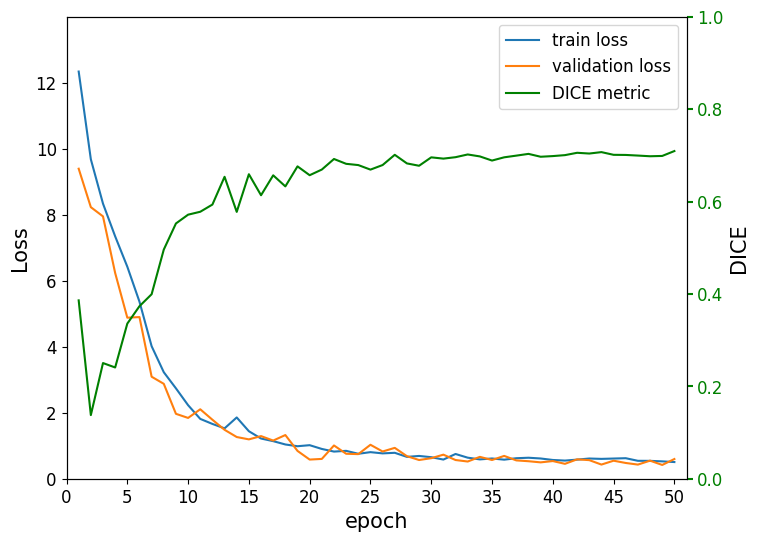

In [63]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) 


twin1 = ax.twinx()
p1, = ax.plot(epochs, loss_train, label="train loss")
p2, = ax.plot(epochs, loss_val, label="validation loss")
p3, = twin1.plot(epochs, dice, "g-", label="DICE metric")

ax.set_xlabel("epoch", fontsize=fontsize+3)
ax.set_ylabel("Loss", fontsize=fontsize+3)
twin1.set_ylabel("DICE", fontsize=fontsize+3)

twin1.tick_params(axis='y', colors=p3.get_color(), **tkw)


ax.set_xticklabels(np.linspace(0, 50, 11).astype(int), fontsize=fontsize)
ax.set_xticks(np.linspace(0, 50, 11))

ax.set_yticklabels(np.linspace(0, 12, 7).astype(int), fontsize=fontsize)
ax.set_yticks(np.linspace(0, 12, 7))

twin1.set_yticklabels(np.round(np.linspace(0, 1, 6),1), fontsize=fontsize)
twin1.set_yticks(np.linspace(0, 1, 6))

ax.set_xlim(0, 51)
ax.set_ylim(0, 14)
twin1.set_ylim(0, 1)

ax.legend(handles=[p1, p2, p3], fontsize=fontsize)

plt.savefig('/home/msst/loss.png')